# Introduction


L'objectif de l'interfaçage d'un instrument est d'envoyer des instructions depuis l'ordinateur afin que celui-ci effectue des opérations normalement faites manuellement. 

## Liste du matériel
* Ordinateur avec installé : anaconda, VISA, pyvisa
* Oscilloscope (Rigol, DS1052E)
* Générateur (Rigol, DG1022)
* Décade de capacités, décades de résistances, bobine 9mH, cables bananes et adaptateurs BNC bananes

## Connexion

Il existe plusieurs type de connexion entre un ordinateur et un instrument. Citons le GPIB, le RS232, l'USB et l'ethernet. 

La GPIB et le RS232 sont des interfaces de communications qui sont obsolètes, mais se trouvent encore fréquemment sur des appareils. Ce sont des interfaces simples, puisqu'on échange des mots d'octets entre les deux appareils. Le RS232 est le port série (COM sous windows). 

L'USB est beaucoup plus complexe car il ne définit par précisément ce qui peut être échangé. Pour l'USB, il est nécessaire d'avoir un driver pour chaque mode de communications. Comme mode de communication, citons l'émulation d'un port série (c'est par exemple ce que l'on retrouve sur les arduinos). Pour les instruments de mesure, une norme appelée USBTMC est utilisée par plusieurs fabricants (USB Test and Measurement Class). Certains fabricants peuvent cependant avoir développé leur propre interface USB.

Enfin, de plus en plus de d'instruments sont connectés par ethernet. Les choses sont en général beaucoup plus simples que l'USB car il n'y a pas besoin de driver spécifique. Des normes de communications existent pour les instrument, en particulier le VXI-11. 

Le VXI-11 et l'USBTMC ont pour but de remplacer le GPIB. Ces protocoles permettent d'échanger des instructions selon une norme précise, le SCPI. 

## SCPI


Le SCPI (Standard Commands for Programmable Instruments) est en quelque sorte la grammaire que l'on va utiliser. Par exemple, pour changer l'échelle verticale d'un oscilloscope on peut envoyer le chaîne : "CH1:SCALE 10". Pour connaître l'échelle verticale on va envoyer "CH1:SCALE?". L'instrument va alors renvoyer une chaîne correspondant à l'échelle. Dans cet exemple, les mots précis dépendent de la marque de l'instrument. Ce que le SCPI défini est la syntaxe et quelques instructions de base. 

Les instructions sont regroupées sous forme d'un arbre. Chaque "branche" est séparée par un ":". Les arguments sont séparés de l'instruction par une espace et sont séparés entre eux par des virgules. Il est aussi possible de transférer des données binaires. Lorsque l'instruction attend une réponse, alors elle est suivie d'un "?". 

Pour connaître l'ensemble des commandes il faut se référer à la partie de la documentation de l'instrument appelée souvent Programmers' User Guide. 

Les instructions de base d'un instrument sont entre autre : 

* ``*IDN?`` qui renvoie une chaîne d'identification unique de l'appareil. Cette chaîne contient : ``<manufacturer>``,``<model number>``,``<serial number>``,``<software revision>`` 
* ``*RST`` qui fait un reset de l'appareil. 

Un dernier point important : le SCPI n'est pas sensible à la casse. De plus chaque instruction possède une version courte et une version longue. Celles-ci sont en général distinguées par la casse. Par exemple "CHannel1:SCAle" signifie que l'on peut utiliser indépendamment CH ou CHANNEL et SCA ou SCALE. 

## VISA

Sous Windows, il est possible d'utiliser un driver VISA qui fournit une interface commune, quelque soit le mode de connexion ou le protocole bas niveau de communication avec l'instrument. La librairie VISA est une librairie propriétaire gratuite fournie par National Instruments. Elle peut être utilisée sous Python avec le module pyvisa (qu'il faut installer en plus de VISA). 

Le logiciel NI-MAX est installé en même temps que VISA. Il permet entre autre de lister l'ensemble des appareils connecté à l'ordinateur et d'envoyer des instructions directement à l'instrument. 


# Connexion


1. Préparation : Manuellement, générez un signal sinusoïdal de fréquence 20 kHz, d'amplitude 5 Vpp et d'offset 0 V sur le channel 1 de votre générateur de fonction arbitraire. Mesurez votre signal à l'aide de l'oscilloscope. Vous utiliserez la fonction "trig" sur un front descendant.

2. Identifiez votre générateur de fréquence arbitraire, en utilisant les commandes de pyvisa :

        import pyvisa
        rm = pyvisa.ResourceManager()
        rm.list_resources()

   

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pyvisa
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x1AB1::0x0588::DS1ET162057882::INSTR',
 'USB0::0x1AB1::0x0588::DG1D122001715::INSTR',
 'ASRL1::INSTR',
 'ASRL3::INSTR')

Les commandes suivantes vous permettront de créer une connection avec votre instrument et de la tester


        instrument = rm.open_resource(chaine_d_identification, query_delay=0.001)
        instrument.query("*IDN?")
        
L'argument optionel ``query_delay`` est indispensable pour le GBF.

3. Créez deux variables (``scope`` et ``gbf``) correspondant à chacun de vos deux instruments

In [2]:
gbf = rm.open_resource('USB0::0x1AB1::0x0588::DG1D122001715::INSTR', query_delay=0.001)
scope = rm.open_resource('USB0::0x1AB1::0x0588::DS1ET162057882::INSTR')

4. Ecrivez une fonction, que l'on testera sur l'oscilloscope, qui renvoie un dictionnaire avec le nom de la compagnie, le nom du modèle, et le numéro de série. 

In [3]:
def get_model_identification(inst):
    res = inst.query("*IDN?")
    comp, model, serial, _ = res.split(',') 
    dic = {'compagnie':comp,
          'model':model,
          'serial':serial}
    return dic

In [4]:
get_model_identification(scope)

{'compagnie': 'Rigol Technologies',
 'model': 'DS1052E',
 'serial': 'DS1ET162057882'}

# Interfaçage du générateur de fonction arbitraire

1. Regardez dans la documentation l'instruction APPL. Programmez une sinusoïde de fréquence 3 kHz, d'amplitude 2 Vpp et avec un offset de 0.5 V.

In [6]:
gbf.write('APPL:SIN 3000,2.0,0.5')

23

Il existe des commandes simples permettant de changer un paramètre unique, par exemple :

        gbf.write('FREQ 1542')
        gbf.query('FREQ?')

Ces fonctions utilisent des chaînes de charactères.
  
2. Écrivez deux fonctions python ``set_frequency`` et ``get_frequency`` qui utilisent des nombres. 

3. Testez votre fonction ``set_frequency`` pour régler la fréquence du signal à 1.123 MHz. Qu'observez vous à l'oscilloscope ? Pourquoi ? 


In [20]:
def set_frequency(inst, freq=1000):
    command = f'FREQ {freq:.3f}'
    inst.write(command)

In [21]:
set_frequency(gbf, freq=1.123e6)

In [22]:
def get_frequency(inst):
    command = f'FREQ?'
    return float(inst.query(command))

In [23]:
get_frequency(gbf)

1123000.0

Nous rappelons la définition de la puissance en unité $dBm$:

$P (dBm) = 10\log(P (mW)) = 20\log(\frac{V_{rms}}{\sqrt{0.001 R}}))$ 

où par convention $P$ est la puissance électrique dissipée dans une résistance de $R=50$ Ohm. Nous rappelons aussi que $V_{pp}=2\sqrt{2}V_{rms}$


4. À la main, avec la fonction utility, réglez le GBF de façon à pouvoir changer l'amplitude du signal en dBm. Pour cela, il faudra régler l'impédance de sortie du GBF en 50 Ohm. Quelle est l'amplitude Vpp du signal que vous mesurez sur l'oscilloscope ? Pourquoi ?

In [24]:
Vrms = 223.607e-3
print(20*np.log(Vrms/np.sqrt(1e-3*50)))
Vpp = 2*np.sqrt(2)*Vrms
print(Vpp*1e3)

1.8089783639e-05
632.456104083


5. Ecrivez une fonction python ``set_amplitude`` qui permet de changer l'amplitude du signal généré. Elle acceptera aussi l'unité Vpp, Vrms, dBm (l'unité par défaut sera Vpp). Il faudra d'abord utiliser une commande pour changer l'unité et ensuite utiliser une commande pour ecrire la valeur de l'amplitude. Entre les deux commandes, on mettra une pause de 100 ms (``from time import sleep``)

In [25]:
from time import sleep
def set_amplitude(inst, amp=5.0, unit='VPP'):
    command_unit = f'VOLT:UNIT {unit}'
    inst.write(command_unit)
    sleep(0.1)
    command = f'VOLT {amp:.3f}'
    inst.write(command)

In [26]:
set_amplitude(gbf, amp=2, unit='VPP')

In [27]:
set_amplitude(gbf, amp=0, unit='DBM')

6. Ecrivez une fonction qui retourne un dictionnaire avec la forme, la fréquence, l'amplitude et l'offset du signal actuellement généré sur le channel 1. On utilisera la commande ``APPL?`` .

In [28]:
def get_all_parameters(inst):
    all_ = inst.query('APPL?',delay=0.001)
    forme, freq, amp, offset = all_[5:-2].split(',')
    dic = {'forme':forme,
          'frequency':float(freq),
          'amplitude':float(amp),
          'offset':float(offset)}
    return dic

In [29]:
get_all_parameters(gbf)

{'amplitude': 0.0, 'forme': 'SIN', 'frequency': 1123000.0, 'offset': 0.5}

7. *(si vous avez le temps)* Ecrivez une fonction qui permet de faire un saut de fréquence de $\delta f$. Cette fonction renvera une exception si la fréquence finale n'est pas comprise entre 1 Hz et 5 MHz.

In [30]:
def add_delta_freq(inst, freq_step):
    freq_init = get_frequency(inst)
    print(f'La fréquence initiale est de {freq_init:3f}')
    freq_final = freq_init + freq_step
    if (freq_final>1) and (freq_final<5e6): 
        set_frequency(inst, freq=freq_final)
        return
    raise Exception(f"La fréquence demandée {freq_final:.2e} n'est pas comprise entre 1 Hz et 5")

In [31]:
add_delta_freq(gbf, 1e6)

La fréquence initiale est de 1123000.000000


# Interfaçage de l'oscilloscope

Comme pour le GBF, il y a un certain nombre de commandes que vous pouvez trouver dans la documentation :
[DS1000DE_ProgrammingGuide_EN.pdf](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/DS1000DE_ProgrammingGuide_EN.pdf)

Par exemple la commande ``:TIMEBASE:SCALE`` permet de connaître ou de programmer l'échelle horizontale. 

1. Essayez cette commande.

In [32]:
scope.query(':TIMEBASE:SCALE?')

'5.000e-07'

La difficulté particulière pour l'oscilloscope est de récupérer la courbe affichée sur celui-ci. La commande ``:WAVEFORM:DATA?`` va renvoyer les donner sous formes binaires. Qu'est-ce que cela signifie ? 

L'échange de donnée entre l'oscilloscope et l'ordinateur se fait par l'échange d'une chaîne d'octet. Lorsque l'on veut envoyer un mot (par exemple ``*IDN?``), celui ci va être encodé avec la table ASCII ([en.wikipedia.org/wiki/ASCII](https://en.wikipedia.org/wiki/ASCII)). Dans ce cas la suite d'octet sera (en décimale) ``42, 73, 68, 78, 63``. De la même façon un nombre écrit en décimal peut être encodé en ASCII : par exemple ``12345`` donnera ``49, 50, 51, 52, 53``. Cependant, un nombre peut être codé plus efficacement : en effet on peut écrire $12345 = 48\times256 + 57$, et décider d'envoyer les deux octets ``48`` et``57``. C'est le codage binaire, codage utilisé par notre oscilloscope. La différence est le même que celle qu'il y a entre ``np.savetxt`` et ``np.save``. 
  
La librairie ``pyvisa`` est capable de décoder automatiquement les données binaires envoyées par l'oscilloscope. Dans notre cas, les ordonnées des points sont des entiers entre 0 et 256 et sont donc codées sur un seul octet. Cela correspond au type de donnée 's' (short). On pourra récupérer les données à l'aide de la commande 

  ``scope.query_binary_values(':WAVEFORM:DATA?', datatype='s')``

2. Utilisez cette commande et affichez la courbe avec matplotlib.

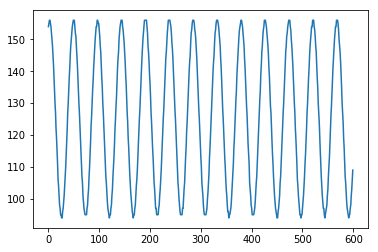

In [33]:
res = scope.query_binary_values(':WAVEFORM:DATA?', datatype='s')
plt.plot(res)

On remarque que les valeurs sont à l'envers (le haut correspond au bas) et qu'il faut les mettre à l'échelle. Cette opération nécéssite de connaître plusieurs paramètres de l'oscilloscope et prend du temps à coder. Nous ne le ferons pas.


# Librairie tpmontrouge

Une librairie a été écrite afin de faciliter l'usage des instruments de la plateforme expérimentale de montrouge (particulièrement la préparation à l'agrégation). L'idée est d'avoir une interface pour chaque type d'instrument indépendament de la marque et du modèle.

La création des objets se fait de la façon suivante

In [40]:
from tpmontrouge.instrument import Scope,GBF, get_first_instrument

scope = get_first_instrument(Scope) # renvoie le premier instrument de type Scope qu'il trouve
gbf = get_first_instrument(GBF)

Le changement d'une valeur peut se faire de deux façon différences : soit à l'aide de fonction soit d'un ``property``. Par exemple : 

    gbf.set_frequency(10E3)
    print(gbf.get_frequency())
    
    gbf.frequency = 10E3
    print(gbf.frequency)


Pour le GBF, nous avons défini les propriétés suivante : ``amplitude``, ``frequency``, ``offset``, ``function``

Pour l'oscilloscope, nous avons plusieurs méthodes ``autoset()``, ``start_acquisition()``, ``stop_acquisition()`` et beaucoup de propriétés. Voici un exemple : 

In [99]:
print('Scale', scope.horizontal.scale, 's/div')
sleep(0.01)
print('Offset', scope.horizontal.offset, 's')
sleep(0.01)
scope.horizontal.scale = 1.0e-4 # s/div
sleep(0.01)
scope.horizontal.offset = 0.0E-3 # s
sleep(0.01)

scope.channel[1].coupling = 'AC'
sleep(0.01)
scope.channel[1].scale = 1.0
sleep(1)
wfm = scope.channel[1].get_waveform()

Scale 0.0001 s/div
Offset 0.0 s


Cette dernière commande renvoie un objet qui contient toute les données de la trace dont ``wfm.x_data`` et ``wfm.y_data``.

3. Utilisez la librairie tpmontrouge pour initisaliser l'oscilloscope et récupérer une trace

# Ajustement (fit) d'une sinusoïde avec un modèle

Voici un example de code permettant d'ajuster un jeu de données par une droite. Nous verrons ceci plus en détails en cours. 


    from scipy.optimize import curve_fit
    def droite(x, a, b):
        return a*x+b
    
    p0 = (.5, 7) # paramètres initiaux
    popt, pcov = curve_fit(droite, x_data, y_data, p0)


Il est important de mettre des paramètres initiaux raisonnables sinon le fit ne convergera pas vers la bonne valeur. Pour cela on tracera la courbe avec ``p0`` (en utlisant ``*p0``)

1. Définissez une fonction sinusoïdale avec les quatre paramètres pertinent : ``offset``, ``amplitude``, ``frequence``, ``phase``. Ajuster la sinusoïde que vous avez récupérée avec l'oscilloscope. Affichez l'amplitude et la phase de la sinusoïde. 

In [100]:
from scipy.optimize import curve_fit

def sinus(t, amplitude, offset, frequence, phase):
    return amplitude*np.sin(2*np.pi*frequence*t + phase) + offset


def fit_sinusoid(wfm, freq):
    a = (wfm.y_data.max()-wfm.y_data.min())/2
    p0 = (a, 0, freq, 0)
    popt, pcov = curve_fit(sinus, wfm.x_data, wfm.y_data, p0)
    if popt[0]<0:
        popt[0], popt[3] = -popt[0], (popt[3]+np.pi)%(2*np.pi)
    return popt

L'amplitude du signal est de 0.644 V et la phase est de 0.784 rad


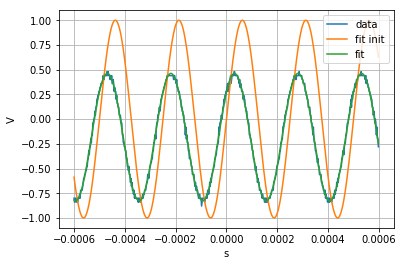

In [103]:
freq0 = 4e3
popt = fit_sinusoid(wfm, freq0)

plt.plot(wfm.x_data,wfm.y_data,label='data')
plt.plot(wfm.x_data,sinus(wfm.x_data,1,0,freq0,0),label='fit init')
plt.plot(wfm.x_data,sinus(wfm.x_data,*popt),label='fit')
plt.legend()
plt.grid()
plt.ylabel('V')
plt.xlabel('s')

print(f"L'amplitude du signal est de {popt[0]:.3f} V et la phase est de {popt[3]:.3f} rad")

# Diagramme de Bode

Nous avons maintenant tous les outils pour faire un diagramme de Bode. Nous proposons de monter le circuit suivant:

![circuit rlc](rlc.pdf "Circuit RLC")

On prendra typiquement $C = 500~\mathrm{pF}$ et $R = 100~\Omega$

L'idée consiste à mesurer l'amplitude et la phase des deux sinusoïdes (entrée et sortie) à l'aide de deux ajustement et de calculer ensuite le gain et le déphasage.

1. Faire un nouveau notebook pour prendre les points du diagramme de Bode et les enregistrer sur l'ordinateur. Avec un autre notebook, analyser les données.

   On pourra utliser la fonction autoset à chaque nouvelle fréquence (et attendre quelques secondes avant d'enregistrer les données).

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.optimize import curve_fit

from time import sleep
from tpmontrouge.instrument import Scope,GBF, get_first_instrument

scope = get_first_instrument(Scope)
gbf = get_first_instrument(GBF)


def sinus(t, amplitude, offset, frequence, phase):
    return amplitude*np.sin(2*np.pi*frequence*t + phase) + offset


def fit_sinusoid(wfm, freq):
    a = (wfm.y_data.max()-wfm.y_data.min())/2
    p0 = (a, 0, freq, 0)
    popt, pcov = curve_fit(sinus, wfm.x_data, wfm.y_data, p0)
    if popt[0]<0:
        popt[0], popt[3] = -popt[0], popt[3]+np.pi
    return popt

def get_bode_point(freq):
    gbf.frequency = freq

    scope.autoset()
    sleep(6)
    wfm1 = scope.get_channel_waveform(1)
    wfm2 = scope.get_channel_waveform(2)
    
    popt1 = fit_sinusoid(wfm1, freq)
    popt2 = fit_sinusoid(wfm2, freq)    
    
    return list(popt1), list(popt2)

Tfreq = np.linspace(40000, 80000, 41)
data = [get_bode_point(freq) for freq in Tfreq]

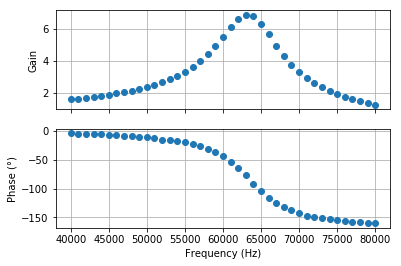

In [107]:
data = np.array(data)

gain = data[:, 1, 0]/data[:, 0, 0]
phase = data[:, 1, -1] - data[:, 0, -1]

phase = np.unwrap(phase)

fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.plot(Tfreq, gain, 'o')
ax1.set_ylabel('Gain')
ax2.plot(Tfreq, 180*phase/np.pi, 'o')
ax2.set_ylabel('Phase (°)')
ax2.set_xlabel('Frequency (Hz)')
ax1.grid()
ax2.grid()

In [12]:
!python remove_cells.py TP_Preparation.ipynb > "TP Instrument.ipynb"
!jupyter nbconvert --to pdf --output-dir=build "TP Instrument.ipynb"

[NbConvertApp] Converting notebook TP Instrument.ipynb to pdf
[NbConvertApp] Writing 36201 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 67787 bytes to build/TP Instrument.pdf
